# Assignment 3
## Alex Masciotra
### 260746829


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt





[[ 23. 106. 174.]
 [111. 153. 193.]]
[[ 63. 124. 178.]
 [218. 215. 196.]
 [ 53.  56.  27.]]


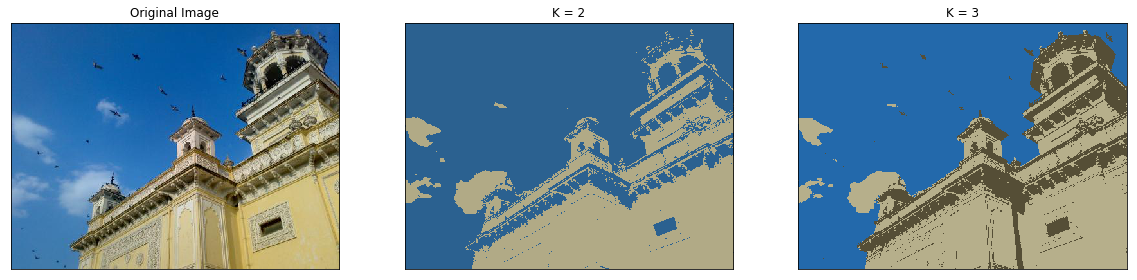

In [2]:
#1.1 K-Means clustering

#Load image
imgsource = "./home.jpg"
imghome = cv2.imread(imgsource)


#convert to RGB
imghome = cv2.cvtColor(imghome, cv2.COLOR_BGR2RGB)
#homeimg = cv2.resize(homeimg, None, fx=0.5, fy=0.5)

#convert image to list since we are measuring pixel intensity and not pixel position
home = imghome.reshape((-1, 3))
home = np.float32(home)

#print(imghome)

#to compute euclidean distance from a point to a centroid and find minumim distance
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

#function to calculate kmeans, inputs = data list and number of clusters
def kmeans(inputlist, numcluster):
        #randomly selecting pixels to be centroids and storing in array
        #C = np.ones([numcluster,3]) #k by 3 array
        C = []

        for i in range(numcluster):
            #C[i] = inputlist[np.random.choice(inputlist.shape[0] - 1, numcluster, False)[i],:]
            C.append(inputlist[np.random.randint(0, inputlist.shape[0]-1)])
        C = np.asarray(C)

        print(C)
    
        
        clusters = np.zeros(len(inputlist), dtype = int)
        #iterating 10 times
        for x in range(0,10):
                #computing distances and assigning to closest cluster
            for i in range(len(inputlist)):
                distances = dist(inputlist[i], C)
                cluster = np.argmin(distances)
                clusters[i] = cluster
           
            # Finding the new centroids by taking the average value
            for i in range(numcluster):
                points = [inputlist[j] for j in range(len(inputlist)) if clusters[j] == i]
                C[i] = np.mean(points, axis=0)
        return clusters, C

        
#calling my funciton to find segmented images        
labels2, centers2 = kmeans(home, 2)
labels3, centers3 = kmeans(home, 3)


#print(labels2)

#to be able to reshape later
centers2 = np.uint8(centers2)
seg2 = centers2[labels2.flatten()]
centers3 = np.uint8(centers3)
seg3 = centers3[labels3.flatten()]


#reshaping images
seg2 = seg2.reshape(imghome.shape)
seg3 = seg3.reshape(imghome.shape)

plt.figure(figsize=(20,20))
plt.subplot(131), plt.imshow(imghome)
plt.xticks([]), plt.yticks([]), plt.title("Original Image")
plt.subplot(132), plt.imshow(seg2)
plt.xticks([]), plt.yticks([]), plt.title("K = 2")
plt.subplot(133), plt.imshow(seg3)
plt.xticks([]), plt.yticks([]), plt.title("K = 3")

plt.show()




[[0.75686276 0.69803923 0.50980395]
 [0.56078434 0.49019608 0.20784314]]
[[0.14117648 0.37254903 0.6313726 ]
 [0.27058825 0.5019608  0.7294118 ]
 [0.80784315 0.7372549  0.40784314]]


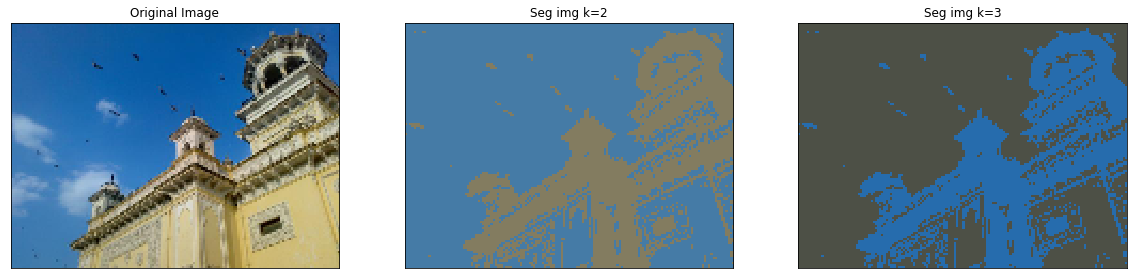

In [10]:
#EM 
#with reference to https://www.python-course.eu/expectation_maximization_and_gaussian_mixture_models.php

#reload image from file to start from scratch
img = cv2.cvtColor(cv2.imread("./home.jpg"), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.3, fy=0.3)#to test faster


#print(homeimg)
homeimg = np.float32(img) #convert to float to keep decimals
homeimg = homeimg / 255 #to keep between 0 and 1
home = np.reshape(homeimg, (homeimg.shape[0] * homeimg.shape[1], -1)) #put into list 


# #now ready to start

def EM (inputlist, numcluster): #will take same arguments as kmeans
    
    #need to initialize random means, covariance and weighting of gaussian mixture models but in multivariate form
    # Decide how many sources/clusters (c) you want to fit to your data
    # Initialize the parameters mean μc, covariance Σc, and fraction_per_class πc per cluster c
    #mean = np.zeros((numcluster,3)) #a k by 3 matrix, 3 for RGB
    mean = []
    cov = np.zeros((numcluster, 3, 3))
    pi_c = np.zeros((numcluster)) #fractionperclass
    
    for i in range(numcluster):
        #find random mean from list, as did for a random cluster center above
        mean.append(inputlist[np.random.randint(0, inputlist.shape[0]-1)])
    mean = np.asarray(mean)

        #mean[i] = inputlist[np.random.randint(0, inputlist.shape[0] - 1)] 
    print(mean)
    cov[:] = np.eye(3) #needs to be identity matrix
    #print(cov)
    pi_c[:] = (1/numcluster) #will always add up to 1
    
    
    #now need to iterate 10 times E-M steps
   
    #probPixel = np.zeros((inputlist.shape[0], numcluster))
    difference = np.zeros((inputlist.shape[0]))
    for x in range(0,10):
        #E-Step Calculate for each datapoint xi the probability ric that datapoint xi belongs to cluster c with
        #probPixel will be returned from this step contains probability pixel is part of which cluster
        probPixel = np.zeros((inputlist.shape[0], numcluster))
        #difference = np.zeroes(data.shape[0])
        for i in range(len(inputlist)):
            for j in range(numcluster):
                #calculating multivariate gaussian
                difference = inputlist[i] - mean[j] #xi - mu
                #computing long gaussian formula
                exptemp = (-1/2)*(np.dot(np.transpose(difference),np.dot(difference,np.linalg.inv(cov[j]))))
                exp = np.exp(exptemp)
                constant = (pi_c[j]* (1/(np.power(2*np.pi, 3/2)*np.sqrt(np.linalg.det(cov[j]))))) #n = 3 cause 3 dimensions
                multiGaussian = constant * exp
                #put into probpixel
                probPixel[i][j] = multiGaussian
            #need to calculate actual probability now and assign to corresponding GMM
            sumrow = sum(probPixel[i])
            probPixel[i] = [probPixel[i][j]/sumrow for j in range(numcluster)] 
        
        
        #M STep
        #need new means and cov 
        newmean = np.zeros((numcluster,3))
        newcov = np.zeros((numcluster,3,3))
        totalprobability = np.zeros((numcluster))
        
        #calculate total weight mc and update pi_c, cov and mu
        for j in range(numcluster):
            for i in range(len(inputlist)):
                totalprobability[j] = (totalprobability[j]) + (probPixel[i][j])
        
        #update pi_c formula found from website
        pi_c = totalprobability / inputlist.shape[0]
        
        #calculate new mean from website
        for j in range(numcluster):
            for i in range(len(inputlist)):
                newmean[j] = newmean[j] + (probPixel[i][j]*inputlist[i])
            newmean[j] = newmean[j] / totalprobability[j]
            
        #new cov formula also website
        for j in range(numcluster):
            for i in range(len(inputlist)):
                difference = (inputlist[i] - newmean[j])[np.newaxis]
                tempdiff = np.dot(np.transpose(difference), difference)
                newcov[j] = newcov[j] + (probPixel[i][j] * tempdiff)
            newcov[j] = newcov[j] / totalprobability[j]
       
        mean = newmean
        cov = newcov
    
    return probPixel, mean

labels2, means2 = EM(home, 2)
labels3, means3 = EM(home, 3)



#make copy to print
homeEM2 = home.copy()
homeEM3 = home.copy()



#finding max probabilities index
for i in range(len(home)):
    maxind = np.argmax(labels2[i])
    homeEM2[i] = means2[maxind]

for i in range(len(home)):
    maxind = np.argmax(labels2[i])
    #take this to get final img
    homeEM3[i] = means3[maxind]


#resize to proper image shape from list

homeEM2 = homeEM2.reshape(homeimg.shape)
homeEM3 = homeEM3.reshape(homeimg.shape)

plt.figure(figsize=(20,20))
plt.subplot(131), plt.imshow(homeimg)
plt.xticks([]), plt.yticks([]), plt.title("Original Image")
plt.subplot(132), plt.imshow(homeEM2)
plt.xticks([]), plt.yticks([]), plt.title("Seg img k=2")
plt.subplot(133), plt.imshow(homeEM3)
plt.xticks([]), plt.yticks([]), plt.title("Seg img k=3")
plt.show()

   

Under what data distribution conditions would K-means and EM give the
same solution, provided similar initializations? (5 points)

Since k-means have centroids only defined by circles, when the data is distributed spherically, kmeans and EM will yield the same result. The reason they do not yield the same result, is that as mentioned above, kmeans has a spherical centroid, while EM has a mean and a covariance to define a "centroid" (gaussian). This means that EM can be spherical but also an elipsoid depending on the covariance. When two clusters have the same covariance, only distance from the mean matters, which is the same as the euclidean distance in the kmeans algorithm.